In [1]:
# Coding
import tensorflow as tf # MAKE SURE TO HAVE TENSORFLOW 2.0 ALPHA0 INSTALLED (pip install tensorflow-gpu==2.0.0-alpha0)
from tensorflow.keras import layers
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Saving models and images
import os
import shutil

In [2]:
# Removing the olg images generated during training
rm_path = "." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "imgs", 
            "." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "models",
            "." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "training_checkpoints_cifar" + os.sep + "ckpt"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

In [3]:
# Loading and normalizing the dataset : MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
# Alterable variables

BATCH_SIZE =    64
EPOCHS =        200
MOMENTUM =      0.9      # Momentum for the Batch Normalization layers

ALPHA = 0.2              # Alpha for the LeakyReLU slope

KERNEL_SIZE =   (5, 5)   # Larger kernel size for the Convolution layers
DROPOUT =       0.4      # Dropout rate
NOISE_DIM =     100      # Amount of features for the generator
LEARNING_RATE = 1e-4     # Learning Rate for the Adam Optimizer
NUM_EXAMPLES =  20       # Amount of examples to generate

In [5]:
# Constructing the generator

def generator_model(input_layer, verbose=False):

    hid = layers.Dense(256 * 7 * 7)(input_layer)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid)
    hid = layers.Reshape((7, 7, 256))(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    hid = layers.UpSampling2D()(hid)
    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, padding="same", use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    hid = layers.UpSampling2D()(hid)
    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, padding="same", use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    hid = layers.Conv2D(1, kernel_size=KERNEL_SIZE, padding="same")(hid)
    out = layers.Activation("tanh")(hid)

    model = tf.keras.Model(inputs=[input_layer], outputs=out)
    if verbose:
        model.summary()
    
    return model

In [6]:
# Constructing the discriminator

def discriminator_model(input_layer, verbose=False):
    
    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same')(input_layer)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid)
    hid = layers.Dropout(DROPOUT)(hid)
    
    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same')(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid)
    hid = layers.Dropout(DROPOUT)(hid)

    hid = layers.Flatten()(hid)

    out = layers.Dense(1)(hid) # No sigmoid activation because we use Cross Entropy with from_logits=True
    
    model = tf.keras.Model(inputs=[input_layer], outputs=out)
    if verbose:
        model.summary()
    
    return model

In [7]:
# Loading the discriminator

img_input = layers.Input(shape=(train_images.shape[1:])) # Input of (32,32,3) as an input for the discriminator
discriminator = discriminator_model(img_input, verbose=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       3328      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0     

In [8]:
# Loading the generator

noise_input = layers.Input(shape=(NOISE_DIM,)) # Input of 100 random numbers for the generator 
generator = generator_model(noise_input, verbose=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 7, 7, 256)         1024      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       1638

In [9]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

In [13]:
checkpoint_dir = "." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "training_checkpoints_cifar"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             g_loss,
                             d_loss,
                             conditions=None,
                             x_axis="scale",
                             y_max=5):

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    if conditions:
        predictions = model([test_input, conditions], training=False)
    else:
        predictions = model([test_input], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i, :, :, 0]+1) / 2, cmap="gray")
        if conditions:
            ax.title.set_text(classes[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
    fig.savefig("." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, train_images.shape[0]//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()


In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be converted 
# from Eager mode of Tensorflow (easier to code but slower to execute) 
# to Graph mode (harder to code but faster to execute)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator([noise] , training=True) 

        # Training the discriminator
        real_output = discriminator([images], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss


In [17]:
g_losses = []
d_losses = []
def train(train_images, epochs):

    num_batches = int(train_images.shape[0]/BATCH_SIZE) # Amount of batches
    for epoch in range(epochs):
        start = time.time() # Timing the epoch

        for batch_idx in range(num_batches):
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            gen_loss, disc_loss = train_step(images)
            
            # Saving the losses
            g_losses.append(gen_loss.numpy())  
            d_losses.append(disc_loss.numpy())

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 g_losses,
                                 d_losses,
                                 x_axis='total')

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               g_losses,
                               d_losses,
                               x_axis='total')

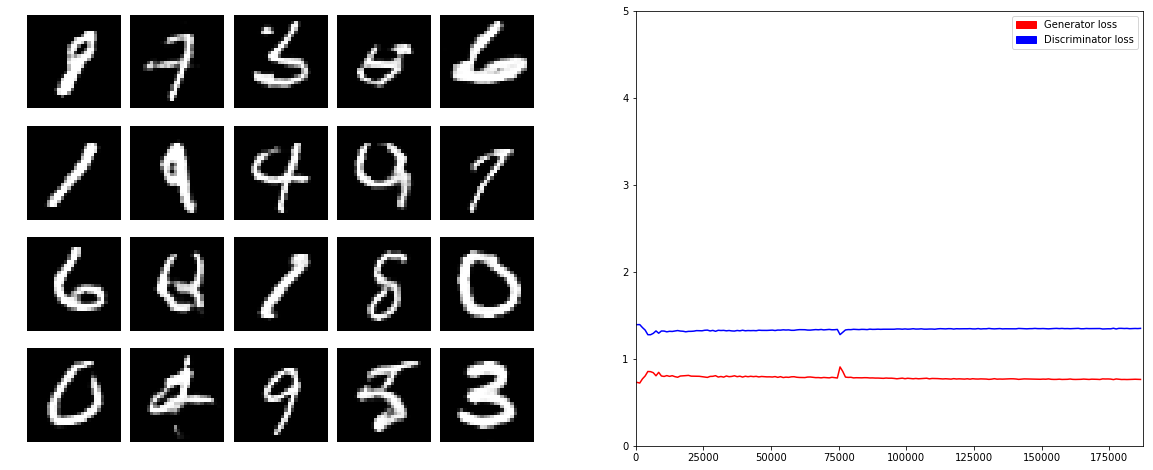

CPU times: user 43min 37s, sys: 8min 4s, total: 51min 42s
Wall time: 2h 37min


In [18]:
%%time
# Training
train(train_images, EPOCHS)

# Immedialty save the models
generator.save("." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + 'models' + os.sep + 'discriminator.h5')

In [19]:
generator_l = tf.keras.models.load_model("." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + "models" + os.sep + "generator.h5")

W0530 14:23:42.749737 140565221353280 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Generating images...


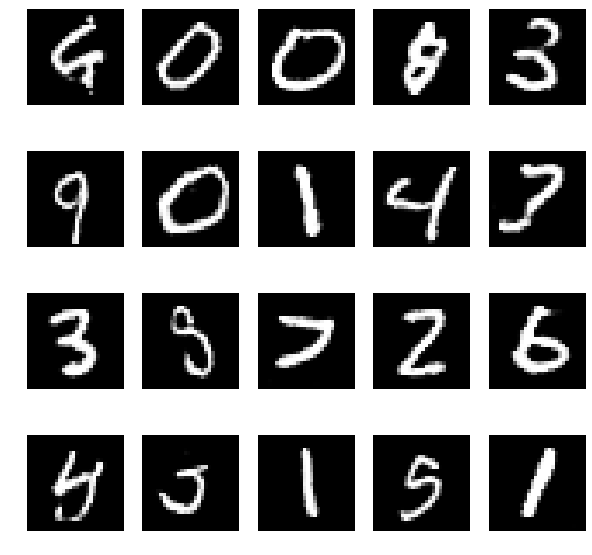

In [20]:
# Show some examples

def show_class(model, k=None, classes=None):
    if classes:
        print("Generating {} images...".format(classes[k]))
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels = tf.one_hot([k]*NUM_EXAMPLES,10)
        predictions = model([input, labels], training=False)
    else:
        print("Generating images...")
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels=None
        predictions = model([input], training=False)
        

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((predictions[i, :, :, 0]+1) / 2, cmap="gray")
        plt.axis('off')
    plt.show()
    
show_class(generator_l)

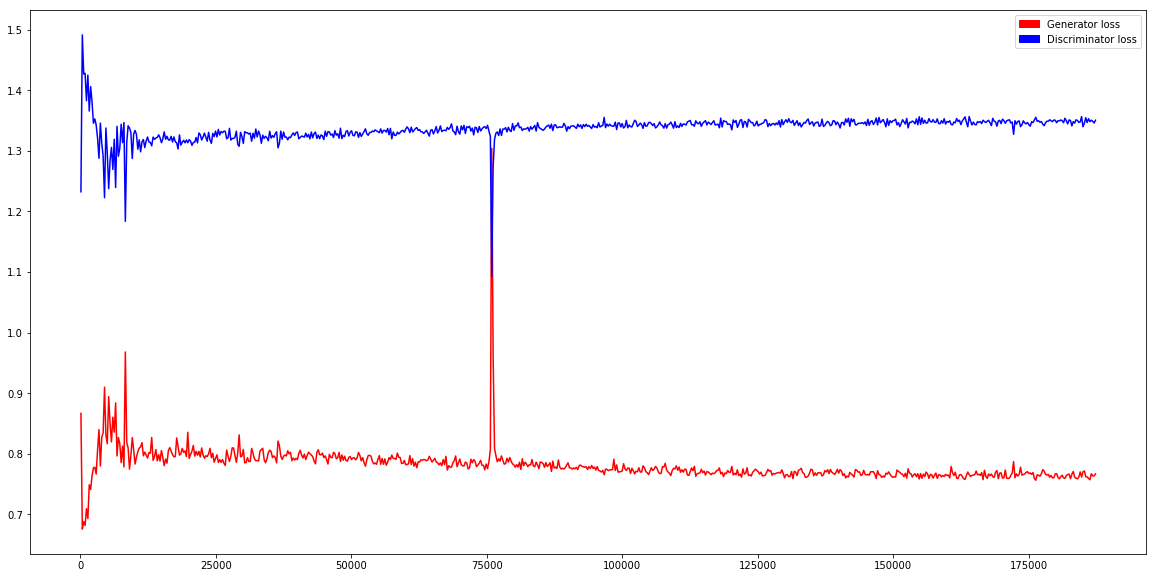

In [21]:
# Visualizing the losses

samples = 256
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


In [22]:
# Creating a GIF image to visualize the training

anim_file = "." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + 'MNIST.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + "1.2_MNIST_GAN_leaky" + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)